In [1]:
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1
from skimage.transform import radon, iradon
import time
from numba import double
from numba.decorators import jit
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

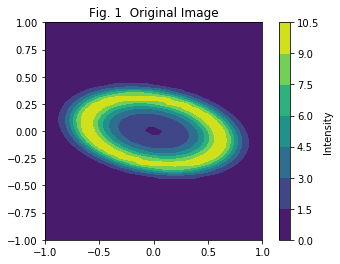

In [2]:
# Make 'Simulation Image'
Bi= 1.98
B0= 2.0
K = np.arctanh(Bi/B0)
R = .6
nm= 10
Range = 41
image = np.zeros((Range,Range))
rad = Range // 2
for i in range(0,Range):
    for j in range(0,Range):
        y = (i - rad) / rad
        x = (-j + rad) /rad
        r = np.sqrt(x**2+4*y**2-x*y)
        if r >= 0.9:
            image[i][j] = 0
        else:
            image[i][j] = nm * 1/(np.cosh(K*(r**2/R**2-1)))
# Plot  'Simulation Image'
x = np.linspace(-1.,1.,Range)
X, Y = np.meshgrid(x, x)
plt.contourf(X,Y,image)
plt.gca().set_aspect('equal',adjustable = 'box')
ax=plt.colorbar()
ax.set_label('Intensity')
plt.title('Fig. 1  Original Image')
plt.show()

In [3]:
# Make [List of Angle]
while 1:
    print("Input Number of Angle")
    num1 = int(input())
    if num1!=0:
        break
φ = np.zeros(2*num1)
φ1 = np.zeros(num1)
for i in range(0,num1):
    print("Input Angle(0~180)  :",i+1)
    φ[i] = input()
    φ[i+num1] = φ[i] +180 
    φ1[i] = φ[i]
φ2 = np.zeros(2*num1)
for n in range(0,2*num1):
    φ2[n] = φ[n]*np.pi/180

Input Number of Angle
6
Input Angle(0~180)  : 1
0
Input Angle(0~180)  : 2
30
Input Angle(0~180)  : 3
60
Input Angle(0~180)  : 4
90
Input Angle(0~180)  : 5
120
Input Angle(0~180)  : 6
150


In [4]:
# To Start the Time Measurement
t = time.time()

In [5]:
# Radon Transform & Conbine Matrix
project = radon(image,theta = φ1, circle=True)/Range*2
image_radon1 = np.zeros((num1,Range))
for i in range(0,num1):
    for j in range(0,Range):
        image_radon1[i][j] = project[j][i]
image_normal = np.zeros(0)
for i in range(0,num1):
    image_normal = np.r_[image_normal,image_radon1[i]]
image_radon2 = np.zeros((num1,Range))
for i in range(0,num1):
    image_radon2[i] = np.array(list(reversed(list(image_radon1[i]))))
image_reverse = np.zeros(0)
for i in range(0,num1):
    image_reverse  = np.r_[image_reverse,image_radon2[i]]
image_original = np.r_[image_normal,image_reverse]

In [6]:
# List of Zero point : Bessel Function
c_number = 9
λ = scipy.special.jn_zeros(0,c_number)
for i in range(0,num1):
    λ1 = scipy.special.jn_zeros(i+1,c_number)
    λ = np.vstack((λ,λ１))

In [7]:
# m-order Bessel Function
%time
@jit
def bessel(m, n, k):   # (order,  order-0-point, 0-point)
    bes = scipy.special.jv(m,λ[n][k])
    return bes

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs


In [8]:
# m-order Bessel Function (radius)
%time
@jit
def bessel2(m, k, r):   # (order, 0-point, radius)
    bes2 = scipy.special.jv(m,λ[m][k]*r)
    return bes2

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


In [9]:
# m-order Bessel Function (diff)
%time
@jit
def d_bessel(m, k):  # (order, 0-point)
    diff = scipy.special.jvp(m,λ[m][k],n=1)
    return diff

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs


In [10]:
# δn  (n = 0  -> 1/2    n ≠ 0  -> 0)
%time
@jit
def delta(n):
    if n == 0:
        a = 1/2
    else:
        a = 1
    return a

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


In [11]:
# Class-2 Tschebysceff Series
%time
@jit
def U(n, p):
    u = np.sin( (n+1) * np.arccos(p) ) / ( (1-p**2)**(1/2) )
    return u

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [12]:
# Analytic Solution of Bessel Function (line 1)
%time
@jit
def f_1(m, k, p):
    f1 = 2*(1-p**2)**(1/2) * d_bessel(m,k)
    return f1

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


In [13]:
# Analytic Solution of Bessel Function (line 2-3)
%time
@jit
def f_2(m, k, p):
    f2 = 0
    for n in range(0,200): # (0,m+1-order) m: bessel-order
        if n != m:
            f2 += delta(n) * bessel(n,m,k) * np.sin(n * (np.pi/2) - (λ[m,k] * p) ) * ( U(m+n-1,p)/(m+n) + U(m-n-1,p)/(m-n) )  
    return f2

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


In [14]:
# Analytic Solution of Bessel Function
%time
@jit
def f_mk(m,k,p):
    fmk = f_1(m,k,p)*f_2(m,k,p)
    return fmk

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


In [15]:
# Make Matrix
%time
@jit
def make_a(p,φ):
    g = np.ones(2*num1*c_number)
    for i in range(0,2*num1):
        if i == 0:
            for k in range(0,c_number):
                g[k] = f_mk(0,k,p)*np.cos(0*φ)
        elif i % 2 == 1:
            for k in range(0,c_number):
                g[k+(i*c_number)] = f_mk((1+i//2),k,p)*np.cos((1+i//2)*φ)
        elif i % 2 == 0:
            for k in range(0,c_number):
                g[k+(i*c_number)] = f_mk((i//2),k,p)*np.sin((i//2)*φ)
    return g

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [16]:
# Conbine Array
%time
@jit
def conb_a(φ,size):
    l = len(φ)
    g = np.ones(2*num1*c_number)
    p = size//2
    for i in range(0,l): # roop about φ
        for j in range(-p,p+1): # roop about p
            px = j / p
            if abs(px) != 1:
                a = make_a(px,φ[i])
                g = np.vstack((g,a))
            else:
                a = np.zeros(2*num1*c_number)
                g = np.vstack((g,a))
    g = np.delete(g,0,0)
    return g

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


In [17]:
# Σamk*Jm(λmkr)*exp(imθ)
%time
@jit
def expand(x,y,A):
    r = np.sqrt(x**2+y**2)
    θ = np.arctan2(y,x)
    Z = 0
    for i in range(0,2*num1):
        if i == 0:
            for k in range(0,c_number):
                Z += A[k]*bessel2(0,k,r)*np.cos(0*θ)
        elif i % 2 == 1:
            for k in range(0,c_number):
                Z += A[k+i*c_number]*bessel2(1+(i//2),k,r)*np.cos((1+i//2)*θ)
        elif i % 2 == 0:
            for k in range(0,c_number):
                Z += A[k+i*c_number]*bessel2((i//2),k,r)*np.sin((i//2)*θ)
    return Z

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


In [18]:
# Σamk*Jm(λmkr)*exp(imθ)
%time
@jit
def expand2(r,θ,A):
    Z = 0
    for i in range(0,2*num1):
        if i == 0:
            for k in range(0,c_number):
                Z += A[k]*bessel2(0,k,r)*np.cos(0*θ)
        elif i % 2 == 1:
            for k in range(0,c_number):
                Z += A[k+i*c_number]*bessel2(1+(i//2),k,r)*np.cos((1+i//2)*θ)
        elif i % 2 == 0:
            for k in range(0,c_number):
                Z += A[k+i*c_number]*bessel2((i//2),k,r)*np.sin((i//2)*θ) 
    return Z

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [19]:
# Luminous Intensity Distribution (1D)
%time
@jit
def plot_1D(A):
    xvec = np.linspace(-1.,1.,41)
    X,Y = np.meshgrid(xvec,xvec)
    Z = -expand(X,Y,A)
    plt.plot(image[20], label = "Original", color = 'b')
    plt.plot(Z[20], 'o', label = "Reconstruction", color = '#ff7f00')
    plt.legend()
    plt.xlabel("Pixels")
    plt.ylabel("Intensity")
    plt.title('Fig. 2  Luminous Intensity Distribution - 1D -')
    plt.show()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.15 µs


In [20]:
# Luminous Intensity Distribution (2D)
%time
@jit
def plot_2D(A):
    X = np.radians(np.linspace(0, 360, 180))
    Y = np.arange(0, 1, 0.01)
    r, theta = np.meshgrid(Y, X)
    values = -expand2(r,theta,A)
    fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
    pp = ax.contourf(theta, r, values)
    plt.suptitle("Fig. 3  Luminous Intensity Distribution - 2D -")
    cbar = plt.colorbar(pp, orientation='vertical')
    cbar.ax.set_ylabel('Intensity')
    plt.show()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


In [21]:
# Luminous Intensity Distribution (2D)
%time
@jit
def plot_2Ds(A):
    x = np.linspace(-1,1,41)
    y = np.linspace(-1,1,41)
    X, Y = np.meshgrid(x, y)
    Z = -expand(X,Y,A)[::-1,::]
    plt.gca().set_aspect('equal', adjustable='box')
    plt.contourf(X,Y,Z)
    plt.suptitle("Fig. 3  Luminous Intensity Distribution - 2D -")
    ax=plt.colorbar()
    ax.set_label('Intensity')
    plt.show()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [22]:
%time
@jit
def matrix_cal(φ,size,image):
    # Make Array
    G = conb_a(φ,size)
    print("Size of G :\t\t " ,G.shape)

    # Transepose
    G_t = G.T
    GtG = np.dot(G_t,G)
    print("Size of GtG　:\t\t" ,GtG.shape)

    # Inverse
    det_GtG = np.linalg.det(GtG)

    # Check det(GtG != 0)
    if det_GtG == 0:
        print("det(GtG) = 0")
    else:
        GtG_inv = np.linalg.pinv(GtG)
        print("Size of GtG_inv :\t" ,GtG_inv.shape)

    # Coefficient Matirix
        C = np.dot(GtG_inv,G_t)
        print("Size of C :\t\t" , C.shape)
        A = np.dot(C,image.T)
    return A

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
Size of G :		  (492, 108)
Size of GtG　:		 (108, 108)
Size of GtG_inv :	 (108, 108)
Size of C :		 (108, 492)


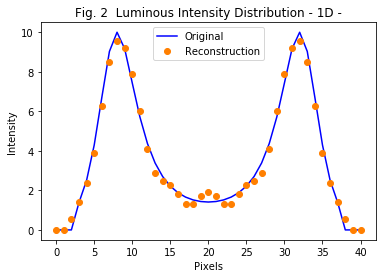

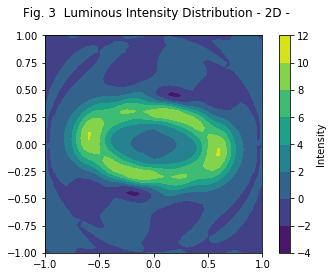

Direction : 6
Run time : 105.26987624168396


In [23]:
# Plot
%time
A1 = matrix_cal(φ2,Range,image_original)
plot_1D(A1)
plot_2Ds(A1)
print("Direction :",num1)
print("Run time :",time.time() - t)